In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
TRAIN_PATH = "/content/gdrive/MyDrive/HandwrittenRecognition/Datasets"

In [ ]:
folder_names = os.listdir(TRAIN_PATH)
files = []

In [ ]:
# Creating Dataframe
class_values = []
filenames = os.listdir(TRAIN_PATH)
class_values = []
for filename in filenames:
    class_val = str(int(filename[:3]))
    class_values.append(class_val)
    

df = pd.DataFrame({
    'filename':filenames,
    'class':class_values
})

In [ ]:
len(df)

1860

In [ ]:
df.head()

,filename,class
0,021t03.tiff,21
1,007t09.tiff,7
2,101t03.tiff,101
3,121t03.tiff,121
4,129t03.tiff,129


In [ ]:
print(len(df['class'].unique()))

156


In [ ]:
print(df['class'].value_counts())

24     12
82     12
103    12
54     12
42     12
       ..
129    10
152    10
124    10
55     10
78     10
Name: class, Length: 156, dtype: int64


In [ ]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=7)
for train_index,validation_index in split.split(df,df['class']):
  train_df = df.loc[train_index]
  val_df = df.loc[validation_index]

In [ ]:
train_df.head()

,filename,class
1108,110t10.tiff,110
249,075t08.tiff,75
1778,152t02.tiff,152
1306,131t03.tiff,131
825,033t02.png,33


In [ ]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [ ]:
train_df.head()

,filename,class
0,110t10.tiff,110
1,075t08.tiff,75
2,152t02.tiff,152
3,131t03.tiff,131
4,033t02.png,33


In [ ]:
val_df.head()

,filename,class
0,104t06.tiff,104
1,031t01.png,31
2,040t05.tiff,40
3,043t07.tiff,43
4,132t02.png,132


In [ ]:
print('Train Dataset Size: ', len(train_df))
print('Validation Dataset Size: ', len(val_df))

Train Dataset Size:  1488
Validation Dataset Size:  372


In [ ]:
train_df.to_csv('/content/gdrive/MyDrive/HandwrittenRecognition/train.csv')
val_df.to_csv('/content/gdrive/MyDrive/HandwrittenRecognition/val.csv')

In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/HandwrittenRecognition/train.csv')
val_df = pd.read_csv('/content/gdrive/MyDrive/HandwrittenRecognition/val.csv')

train_df['class'] = train_df['class'].astype(str)
val_df['class'] = val_df['class'].astype(str)



In [ ]:
train_df.head()

,Unnamed: 0,filename,class
0,0,110t10.tiff,110
1,1,075t08.tiff,75
2,2,152t02.tiff,152
3,3,131t03.tiff,131
4,4,033t02.png,33


In [ ]:
val_df.head()

,Unnamed: 0,filename,class
0,0,104t06.tiff,104
1,1,031t01.png,31
2,2,040t05.tiff,40
3,3,043t07.tiff,43
4,4,132t02.png,132


In [ ]:
batch_size = 8
epoch = 100

train_count = train_df.shape[0]
val_count = val_df.shape[0]

train_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = 'filename',
    y_col = 'class',
    class_mode = 'categorical',
    target_size = (128,128),
    batch_size = batch_size,
    color_mode='grayscale',
)

val_gen = train_datagen.flow_from_dataframe(
    val_df,
    directory = TRAIN_PATH,
    x_col = 'filename',
    y_col = 'class',
    class_mode = 'categorical',
    target_size = (128,128),
    batch_size = batch_size,
    color_mode='grayscale',
) 

Found 1488 validated image filenames belonging to 156 classes.
Found 372 validated image filenames belonging to 156 classes.


In [ ]:
train_gen.class_indices == val_gen.class_indices

True

In [ ]:
def build_model():
    
    model = models.Sequential()

    model.add(layers.Conv2D(64, 5, activation='relu',padding = 'same' ,input_shape=(128,128,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(3))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(3))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, 3,activation='relu',padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(156, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

model = build_model()

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1664      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 42, 42, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 42, 42, 128)      5

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystop = EarlyStopping(monitor='val_accuracy' ,patience=10,restore_best_weights=True,mode='max')
lrreducuction = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=2, verbose=1, min_lr=0.000005)
filepath = "/content/gdrive/MyDrive/TamilCharacterRecognition/models/checkpoint.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [earlystop, lrreducuction, checkpoint]

In [ ]:
history = model.fit(
    train_gen,
    epochs=epoch,
    steps_per_epoch = train_count // batch_size,
    validation_data = val_gen,
    validation_steps = val_count // batch_size,
    callbacks = callbacks
)

Epoch 1/100
186/186 [==============================] - ETA: 0s - loss: 4.3526 - accuracy: 0.1216
Epoch 00001: val_accuracy improved from -inf to 0.11413, saving model to /content/gdrive/MyDrive/TamilCharacterRecognition/models/checkpoint.h5
186/186 [==============================] - 494s 3s/step - loss: 4.3526 - accuracy: 0.1216 - val_loss: 4.5645 - val_accuracy: 0.1141 - lr: 0.0010
Epoch 2/100
185/186 [============================>.] - ETA: 0s - loss: 3.0930 - accuracy: 0.3730
Epoch 00002: val_accuracy improved from 0.11413 to 0.51630, saving model to /content/gdrive/MyDrive/TamilCharacterRecognition/models/checkpoint.h5
186/186 [==============================] - 6s 35ms/step - loss: 3.0947 - accuracy: 0.3716 - val_loss: 2.3263 - val_accuracy: 0.5163 - lr: 0.0010
Epoch 3/100
185/186 [============================>.] - ETA: 0s - loss: 2.2269 - accuracy: 0.5703
Epoch 00003: val_accuracy improved from 0.51630 to 0.60870, saving model to /content/gdrive/MyDrive/TamilCharacterRecognition/mo

In [ ]:
model.save_weights("/content/gdrive/MyDrive/HandwrittenRecognition/models/tamil_OCR_weights81.25.h5")

In [ ]:
model.save("/content/gdrive/MyDrive/HandwrittenRecognition/models/tamil_OCR_model81.25.h5")

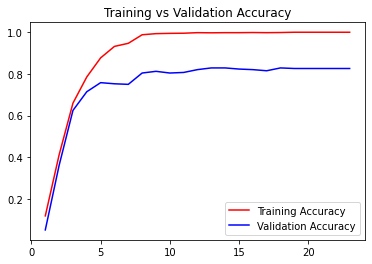

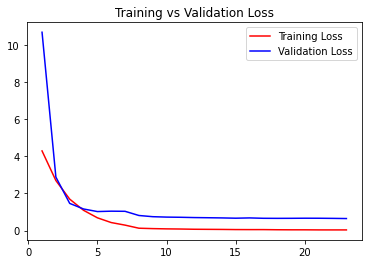

In [ ]:
epoch_xaxis = range(1, len(history.history['accuracy'])+1)

plt.plot(epoch_xaxis, history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(epoch_xaxis, history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.figure()

plt.plot(epoch_xaxis, history.history['loss'], 'r', label='Training Loss')
plt.plot(epoch_xaxis, history.history['val_loss'], 'b', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/HandwrittenRecognition/src')

In [ ]:
from CharMapper import classToChar

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/HandwrittenRecognition/models/tamil_OCR_model82.88.h5')

In [ ]:
def find_actual_class(indice):
  for key,val in val_gen.class_indices.items():
    if val==indice:
      return int(key)
  print("Indice Not Found")

In [ ]:
def test_single_img(path):
  imgPIL = load_img(path,color_mode='grayscale',target_size=(128,128))
  img = img_to_array(imgPIL)
  img = img.reshape(-1,128,128,1)
  y_prob = model.predict(img)
  y_class_id = y_prob.argmax(axis=1)[0]
  y_class = find_actual_class(y_class_id)
  print(y_class)
  return classToChar(y_class)


In [ ]:
test_single_img('/content/gdrive/MyDrive/HandwrittenRecognition/Datasets/001t09.tiff')

1


'ஆ'

In [ ]:
model.evaluate(train_gen,return_dict=True)

186/186 [==============================] - 4s 20ms/step - loss: 0.1608 - accuracy: 0.9637


{'accuracy': 0.9637096524238586, 'loss': 0.16078484058380127}

In [ ]:
model.evaluate(val_gen,return_dict=True)

47/47 [==============================] - 1s 20ms/step - loss: 0.1479 - accuracy: 0.9677


{'accuracy': 0.9677419066429138, 'loss': 0.14790257811546326}